In [1]:
#pytorch lib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset,random_split
import torch.optim as optim


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,shutil,warnings
import glob
import random 
import rasterio
import json

from transformers import ViTForImageClassification
from tqdm import tqdm
from PIL import Image
from IPython.display import display
from torchvision import transforms
from typing import Tuple, Dict, List

from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


random.seed(69)


## Data Preperation
Since the image already formatted in "Classname/imagename.png", we can use utility function from PyTorch called "Image Folder" to prepare the image for us

In [2]:
#get all the classes
root_dir = "datasets/EuroSAT/"
transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),  # Converts to a tensor and scales values to [0, 1]
    #transforms.ConvertImageDtype(torch.float32),
])
dataset = datasets.ImageFolder(root=root_dir, transform=transform, )

train_size = int(0.9*len(dataset))
test_size  = len(dataset) - train_size

In [3]:
train_dataset,val_dataset = random_split(dataset,[train_size,test_size])


dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", attn_implementation="sdpa", torch_dtype=torch.float32)
model.classifier = nn.Linear(model.classifier.in_features,10)

In [5]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        #print("test")
        outputs = model(images)
        
        logits = outputs.logits
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        progress_bar.set_postfix(loss=running_loss/len(progress_bar))
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")
    if (epoch + 1) % 10 == 0:
        # 
        torch.save(model.state_dict(), f'weights/vit_model_{epoch+1}.pth')

print("Finished Training")

Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:48<00:00,  4.51batch/s, loss=1.74]


Epoch [1/100], Loss: 1.7383906964408724


Epoch 2/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:46<00:00,  4.58batch/s, loss=1.01]


Epoch [2/100], Loss: 1.0091244650122366


Epoch 3/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:46<00:00,  4.57batch/s, loss=0.78]


Epoch [3/100], Loss: 0.7804883542421617


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:48<00:00,  4.51batch/s, loss=0.679]


Epoch [4/100], Loss: 0.6786459825540844


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:50<00:00,  4.46batch/s, loss=0.531]


Epoch [5/100], Loss: 0.5312600651657895


Epoch 6/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:50<00:00,  4.46batch/s, loss=0.47]


Epoch [6/100], Loss: 0.4698689803187


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:51<00:00,  4.43batch/s, loss=0.416]


Epoch [7/100], Loss: 0.4157060724143919


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:52<00:00,  4.42batch/s, loss=0.384]


Epoch [8/100], Loss: 0.3842230343308888


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:52<00:00,  4.41batch/s, loss=0.355]


Epoch [9/100], Loss: 0.3547593051371606


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:52<00:00,  4.41batch/s, loss=0.341]


Epoch [10/100], Loss: 0.3411136121783209


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:52<00:00,  4.40batch/s, loss=0.312]


Epoch [11/100], Loss: 0.31161872123515133


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:53<00:00,  4.39batch/s, loss=0.293]


Epoch [12/100], Loss: 0.2929603507497201


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:51<00:00,  4.43batch/s, loss=0.271]


Epoch [13/100], Loss: 0.27111974752164986


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:53<00:00,  4.37batch/s, loss=0.256]


Epoch [14/100], Loss: 0.2562172374271445


Epoch 15/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:52<00:00,  4.40batch/s, loss=0.23]


Epoch [15/100], Loss: 0.2301556418380259


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:52<00:00,  4.39batch/s, loss=0.224]


Epoch [16/100], Loss: 0.2244119530494668


Epoch 17/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:53<00:00,  4.39batch/s, loss=0.214]


Epoch [17/100], Loss: 0.21441347367179237


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:53<00:00,  4.38batch/s, loss=0.205]


Epoch [18/100], Loss: 0.2047776779527531


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:52<00:00,  4.40batch/s, loss=0.187]


Epoch [19/100], Loss: 0.18693794960303134


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:52<00:00,  4.39batch/s, loss=0.172]


Epoch [20/100], Loss: 0.17215889905775456


Epoch 21/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:52<00:00,  4.40batch/s, loss=0.165]


Epoch [21/100], Loss: 0.16499742873527698


Epoch 22/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:54<00:00,  4.36batch/s, loss=0.164]


Epoch [22/100], Loss: 0.16361821932460818


Epoch 23/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:53<00:00,  4.39batch/s, loss=0.147]


Epoch [23/100], Loss: 0.14671775570972578


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:53<00:00,  4.38batch/s, loss=0.152]


Epoch [24/100], Loss: 0.15240921309021743


Epoch 25/100:  34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 261/760 [00:59<01:54,  4.37batch/s, loss=0.0416]

Accuracy : 98.88888888888889
Precision : 0.9885062051006714
Recall : 0.9889663807423001


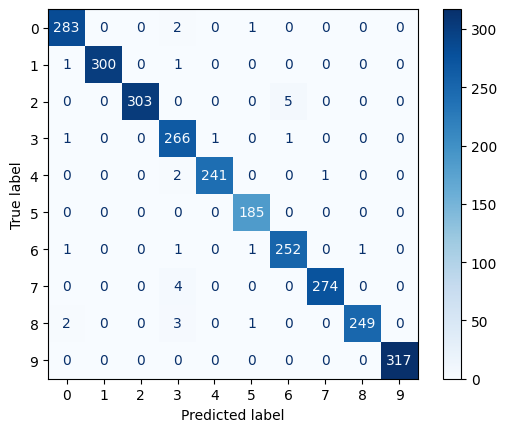

In [11]:
model.load_state_dict(torch.load('weights/vit_model_100.pth'))
model.eval()  # Set the model to evaluation mode
model.to(device)
val_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc='Evaluating', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        
        outputs = model(inputs)
        logits = outputs.logits
        loss = criterion(logits, labels)
        val_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
cm = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues')

print("Accuracy :",accuracy)
print("Precision :" ,precision)
print("Recall :", recall)
